#### NSL-KDD Training using Ensemble model combining the decisions of KNN , Random Forest , Decision Tree and Logistic Reression

In [1]:
#Importing essential libraries
from sklearn.datasets import fetch_openml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os 
import cv2
import random 
import math
import imblearn

from datetime import datetime

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras

In [2]:
df1 = pd.read_csv('cic_ids2017_botnet.csv')
df2 = pd.read_csv('cic_ids2017_brute_force.csv')
df3 = pd.read_csv('cic_ids2017_ddos.csv')
df4 = pd.read_csv('cic_ids2017_dos_ddos.csv')
df5 = pd.read_csv('cic_ids2017_infilteration.csv')
df6 = pd.read_csv('cic_ids2017_port_scan.csv')
df7 = pd.read_csv('cic_ids2017_web_attacks.csv')

In [3]:
#Grouping the similar labels 
df2['label']= df2['label'].replace(["FTP-BruteForce","SSH-Bruteforce"],"BruteForce")
df4['label']= df4['label'].replace(["DoS attacks-Hulk","DoS attacks-GoldenEye","DoS attacks-Slowloris","DoS attacks-SlowHTTPTest","Heartbleed"],"DoS")
df7['label']= df7['label'].replace(["Brute Force -Web","Brute Force -XSS","SQL Injection"],"WebAttack")


In [4]:
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7

In [5]:
#Dropping timestamp column
df=df.drop(columns=['timestamp'])

In [6]:
df['label'].value_counts()

Benign           1743179
DoS               252672
PortScan          158930
DDOS LOIT         128027
BruteForce         13835
WebAttack           2180
Bot                 1966
Infilteration         36
Name: label, dtype: int64

In [7]:
# drop one variable features 
one_variable_list = []
for i in df.columns:
    if df[i].value_counts().nunique() < 2:
        one_variable_list.append(i)
df.drop(one_variable_list,axis=1,inplace=True)
df.columns =  df.columns.str.strip()

In [8]:
df.shape

(2300825, 71)

In [9]:
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [10]:
df.shape

(2298395, 71)

In [11]:
df =  df.drop_duplicates(keep="first")
df.reset_index(drop=True,inplace=True)

In [12]:
df.shape

(2018473, 71)

In [13]:
data = df.copy()

In [14]:
data['label'].unique()

array(['Benign', 'Bot', 'BruteForce', 'DDOS LOIT', 'DoS', 'Infilteration',
       'PortScan', 'WebAttack'], dtype=object)

In [15]:
df['label'].unique()

array(['Benign', 'Bot', 'BruteForce', 'DDOS LOIT', 'DoS', 'Infilteration',
       'PortScan', 'WebAttack'], dtype=object)

In [16]:
#Scaling the dataset 
#Converting the dataset types to optimise the memory usage 
for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)
            
    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)
            
            

attackType = data['label'].unique()
data['label'] = data['label'].astype('category')
data['label'] = data['label'].astype("category").cat.codes

In [17]:
data['label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int8)

In [18]:
data['label']=data['label'].replace([1,2,3,4,5,6,7],+1)

In [19]:
data['label'].value_counts()

0    1592732
1     425741
Name: label, dtype: int64

In [20]:
y = data['label'].copy()
X = data.drop(['label'],axis=1)

In [21]:
print('X ',X.shape)
print('y ',y.shape)

X  (2018473, 70)
y  (2018473,)


In [22]:
digit_train, counts_train = np.unique(y, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

{0: 1592732, 1: 425741}


#### Balancing The Imbalanced Data

In [23]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler('majority')
X_rus, y_rus = rus.fit_sample(X, y)

e:\code\ml\my_env\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


In [24]:
print('X_rus ',X_rus.shape)
print('y_rus ',y_rus.shape)

X_rus  (851482, 70)
y_rus  (851482,)


In [25]:
digit_train, counts_train = np.unique(y_rus, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

{0: 425741, 1: 425741}


In [26]:
y_rus.value_counts()

1    425741
0    425741
Name: label, dtype: int64

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = X.select_dtypes(include=['float32','float16','int32','int16','int8']).columns
train_X = scaler.fit_transform(X.select_dtypes(include=['float32','float16','int32','int16','int8']))

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X_rus,y_rus,train_size=0.70, random_state=2)

In [29]:
print('X_train :',X_train.shape)
print('Y_train :',Y_train.shape)
print('X_test  :',X_test.shape)
print('Y_test  :',Y_test.shape)

X_train : (596037, 70)
Y_train : (596037,)
X_test  : (255445, 70)
Y_test  : (255445,)


In [30]:
digit_train, counts_train = np.unique(Y_train, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

{0: 297959, 1: 298078}


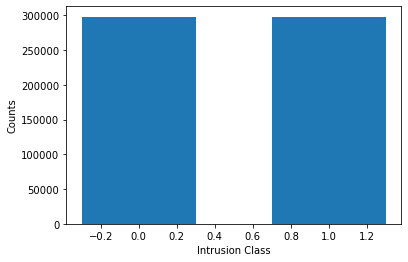

In [31]:
plt.bar(list(distribution_train.keys()),distribution_train.values(),width =0.6)
plt.xlabel('Intrusion Class')
plt.ylabel('Counts')
plt.show()

In [32]:
digit_train, counts_train = np.unique(Y_test, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

{0: 127782, 1: 127663}


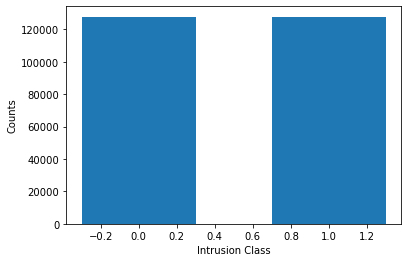

In [33]:
plt.bar(list(distribution_train.keys()),distribution_train.values(),width =0.6)
plt.xlabel('Intrusion Class')
plt.ylabel('Counts')
plt.show()

In [34]:
# compare standalone models for binary classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier

# define the base models
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('cart', DecisionTreeClassifier()))
level0.append(('RF', RandomForestClassifier(max_depth=40)))
level1 = LogisticRegression()
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
model.fit(X_train, Y_train)
#model.fit(X_train_minmax, Y_train)

e:\code\ml\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\code\ml\my_env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opt

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression()),
                               ('knn', KNeighborsClassifier()),
                               ('cart', DecisionTreeClassifier()),
                               ('RF', RandomForestClassifier(max_depth=40))],
                   final_estimator=LogisticRegression())

In [35]:
Y_test_pred1 = model.predict(X_test)

In [36]:
print("Train score is:", model.score(X_train, Y_train))
print("Test score is:",model.score(X_test, Y_test))

Train score is: 0.9998473249143929
Test score is: 0.9986376715144161


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(Y_test_pred1, Y_test))
print('Classification Report')
print(classification_report(Y_test_pred1, Y_test))

Confusion Matrix
[[127598    164]
 [   184 127499]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127762
           1       1.00      1.00      1.00    127683

    accuracy                           1.00    255445
   macro avg       1.00      1.00      1.00    255445
weighted avg       1.00      1.00      1.00    255445



In [38]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

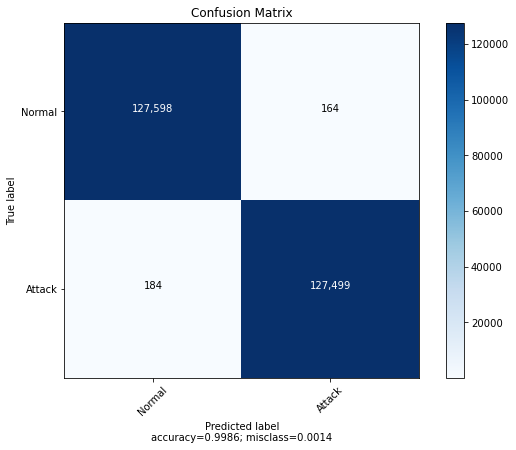

In [41]:
plot_confusion_matrix(confusion_matrix(Y_test_pred1, Y_test), 
                      normalize    = False,
                      target_names = ["Normal","Attack"],
                      title        = "Confusion Matrix")

Basic Model: ROC AUC=0.500
Ensemble Model: ROC AUC=1.000


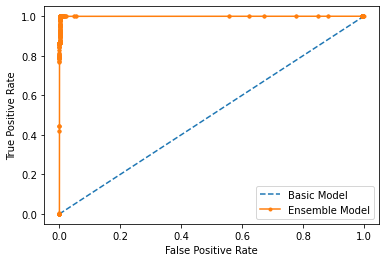

In [43]:
#Area under the ROC Curve
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
bm_probs = [0 for _ in range(len(Y_test))]
# predict probabilities
em_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
em_probs = em_probs[:, 1]
# calculate scores
bm_auc = roc_auc_score(Y_test, bm_probs)
em_auc = roc_auc_score(Y_test, em_probs)
# summarize scores
print('Basic Model: ROC AUC=%.3f' % (bm_auc))
print('Ensemble Model: ROC AUC=%.3f' % (em_auc))
# calculate roc curves
bm_fpr, bm_tpr, _ = roc_curve(Y_test, bm_probs)
em_fpr, em_tpr, _ = roc_curve(Y_test, em_probs)
# plot the roc curve for the model
pyplot.plot(bm_fpr, bm_tpr, linestyle='--', label='Basic Model')
pyplot.plot(em_fpr, em_tpr, marker='.', label='Ensemble Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()